## Importing Libraries

In [3]:
# Importing libraries
import numpy as np
import pandas as pd

# For loading data from SQL Database
import pyodbc as podbc
# For Exporting data to SQL Database
from sqlalchemy import create_engine
import urllib


# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl 

# For analysis
import math

# For finding optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gap_statistic import OptimalK


# For Standardization
from sklearn.preprocessing import StandardScaler

#For warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='wa

## Loading Data

In [4]:
#Loading data from SQL Database

ap = podbc.connect("Driver={SQL Server Native Client 11.0};"
                  "Server=insert_server_name;"
                  "Database=insert_database_name;"
                  "Trusted_Connection=yes;", 
                 dtype={'DONOR USER ID': str, 'FUNDRAISER USER ID': str, 'EVENT ID': str})

# running the sql query 
ap = pd.read_sql_query('''SELECT * FROM [dbo].[fund6]''', ap)

ap.head

<bound method NDFrame.head of         Fundraiser User ID PROMOTED EVENT                EVENT CATEGORY  \
0                   9185.0            Yes           Running / marathons   
1                   9185.0             No                         Treks   
2                   9185.0            Yes           Running / marathons   
3                   9185.0             No                         Treks   
4                   9185.0            Yes           Running / marathons   
...                    ...            ...                           ...   
100113          75941911.0             No      Other personal challenge   
100114          75941911.0             No      Other personal challenge   
100115          75941911.0             No      Other personal challenge   
100116          75944563.0             No  Personal running / marathons   
100117          75958167.0            Yes           Running / marathons   

       EVENT DATE Source Code                                 APPEAL 

## Data Preprocessing

In [5]:
# Checking for missing data
ap.isnull().sum()

Fundraiser User ID                0
PROMOTED EVENT                    0
EVENT CATEGORY                    0
EVENT DATE                        0
Source Code                     846
APPEAL NAME                       0
Page Created Date                 0
Fundraising Page Status           0
TOTAL DONATIONS                   0
FUNDRAISER TARGET AMOUNT          0
USER-CREATED EVENT                0
FUNDRAISER COUNTY/STATE       15614
Number of Online donations        0
Event Name                        0
EVENT ID                          0
DONOR USER ID                  2424
DONATION DATE                  2424
DONATION AUTH AMOUNT           2424
PAYMENT TYPE                   2424
dtype: int64

In [6]:
# Removing missing values
ap = ap[~ap['DONOR USER ID'].isnull()]
ap.notna()

,Fundraiser User ID,PROMOTED EVENT,EVENT CATEGORY,EVENT DATE,Source Code,APPEAL NAME,Page Created Date,Fundraising Page Status,TOTAL DONATIONS,FUNDRAISER TARGET AMOUNT,USER-CREATED EVENT,FUNDRAISER COUNTY/STATE,Number of Online donations,Event Name,EVENT ID,DONOR USER ID,DONATION DATE,DONATION AUTH AMOUNT,PAYMENT TYPE
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100112,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
100113,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
100114,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
100115,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [7]:
# Checking for duplicated entries
print('Duplicated Entries: {}'.format(ap.duplicated().sum()))


Duplicated Entries: 9763


In [8]:
# Deleting duplicated entries
ap.drop_duplicates(inplace = True)

In [9]:
# Checking the new shape of the data
ap.shape 

(87931, 19)

In [10]:
# Replacing space in columns with underscore
ap.columns = [c.replace(' ', '_') for c in ap.columns]

ap.columns

Index(['Fundraiser_User_ID', 'PROMOTED_EVENT', 'EVENT_CATEGORY', 'EVENT_DATE',
       'Source_Code', 'APPEAL_NAME', 'Page_Created_Date',
       'Fundraising_Page_Status', 'TOTAL_DONATIONS',
       'FUNDRAISER_TARGET_AMOUNT', 'USER-CREATED_EVENT',
       'FUNDRAISER_COUNTY/STATE', 'Number_of_Online_donations', 'Event_Name',
       'EVENT_ID', 'DONOR_USER_ID', 'DONATION_DATE', 'DONATION_AUTH_AMOUNT',
       'PAYMENT_TYPE'],
      dtype='object')

In [11]:
# Creating a column "donation_number" with sequential integers (10-1010) to uiquely identify each donation
f=len(ap)
ap['donation_number'] = np.nan
g = list(range(10,f+10))
g = pd.Series(g)
ap['donation_number'] = g.values
ap

,Fundraiser_User_ID,PROMOTED_EVENT,EVENT_CATEGORY,EVENT_DATE,Source_Code,APPEAL_NAME,Page_Created_Date,Fundraising_Page_Status,TOTAL_DONATIONS,FUNDRAISER_TARGET_AMOUNT,USER-CREATED_EVENT,FUNDRAISER_COUNTY/STATE,Number_of_Online_donations,Event_Name,EVENT_ID,DONOR_USER_ID,DONATION_DATE,DONATION_AUTH_AMOUNT,PAYMENT_TYPE,donation_number
0,9185.0,Yes,Running / marathons,2021-08-01,LLHSPO,#WishHeroes of London Landmarks 2020,2020-01-29,Completed,355.00,350.0,No,Surrey,19.0,London Landmarks Half Marathon 2021,5223437.0,65086821.0,2021-05-23,60.0,Visa Delta,10
1,9185.0,No,Treks,2021-05-22,ULTSPO,Make A Wish Foundation UK - Default Appeal,2021-05-20,Completed,1055.00,0.0,No,Surrey,38.0,Jurassic Coast Challenge,5918601.0,65086821.0,2021-05-23,60.0,Visa Delta,11
2,9185.0,Yes,Running / marathons,2021-08-01,LLHSPO,#WishHeroes of London Landmarks 2020,2020-01-29,Completed,355.00,350.0,No,Surrey,19.0,London Landmarks Half Marathon 2021,5223437.0,71058873.0,2021-05-24,30.0,ApplePay MasterCard Credit,12
3,9185.0,No,Treks,2021-05-22,ULTSPO,Make A Wish Foundation UK - Default Appeal,2021-05-20,Completed,1055.00,0.0,No,Surrey,38.0,Jurassic Coast Challenge,5918601.0,71058873.0,2021-05-24,30.0,ApplePay MasterCard Credit,13
4,9185.0,Yes,Running / marathons,2021-08-01,LLHSPO,#WishHeroes of London Landmarks 2020,2020-01-29,Completed,355.00,350.0,No,Surrey,19.0,London Landmarks Half Marathon 2021,5223437.0,65086821.0,2021-05-29,30.0,ApplePay Visa Debit,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100112,75941911.0,No,Other personal challenge,2021-12-10,CELOTH,Make A Wish Foundation UK - Default Appeal,2021-12-07,Active,151.00,0.0,Yes,Hertfordshire,19.0,Computacenter Christmas Jumper Day,7231793.0,75941911.0,2021-12-10,5.0,Paypal,87936
100113,75941911.0,No,Other personal challenge,2021-12-10,CELOTH,Make A Wish Foundation UK - Default Appeal,2021-12-07,Active,151.00,0.0,Yes,Hertfordshire,19.0,Computacenter Christmas Jumper Day,7231793.0,65086821.0,2021-12-13,24.0,Visa Delta,87937
100114,75941911.0,No,Other personal challenge,2021-12-10,CELOTH,Make A Wish Foundation UK - Default Appeal,2021-12-07,Active,151.00,0.0,Yes,Hertfordshire,19.0,Computacenter Christmas Jumper Day,7231793.0,65086821.0,2021-12-13,4.0,Visa Delta,87938
100115,75941911.0,No,Other personal challenge,2021-12-10,CELOTH,Make A Wish Foundation UK - Default Appeal,2021-12-07,Active,151.00,0.0,Yes,Hertfordshire,19.0,Computacenter Christmas Jumper Day,7231793.0,65086821.0,2021-12-21,10.0,MasterCard,87939


## Data Exploration

In [12]:
########## EXPLORING THE NUMBER OF TIMES DONATIONS WERE MADE OVER THE FOUR YEARS PERIOD ###########

# Number of events, number of donations and number of donors
pd.DataFrame([{'events': len(ap['EVENT_ID'].value_counts()),    
               'donations': len(ap['donation_number'].value_counts()),
               'donors': len(ap['DONOR_USER_ID'].value_counts()),  
              }], columns = ['events', 'donations', 'donors'], 
             index = ['quantity'])

,events,donations,donors
quantity,1693,87931,26962


In [13]:
############# EXPLORING THE NUMBER OF DONATIONS TO AN EVENT PER DATE ################

# Number of donations made per date
temp = ap.groupby(by=['DONOR_USER_ID', 'EVENT_ID'], as_index=False)['DONATION_DATE'].count()
temp2 = temp.rename(columns = {'DONATION_DATE':'Number of donations'})
temp2[:10].sort_values('DONOR_USER_ID')

,DONOR_USER_ID,EVENT_ID,Number of donations
0,0.0,4590237.0,3
1,0.0,4606054.0,7
2,0.0,4649523.0,2
3,0.0,4868396.0,3
4,0.0,4896064.0,3
5,0.0,4912413.0,3
6,0.0,4917226.0,2
7,0.0,4971562.0,1
8,0.0,5047022.0,1
9,0.0,5223437.0,2


In [14]:
############# EXPLORING THE RELATION STRENGTH BETWEEN A DONOR AND AN EVENT  ################

# Define donor strength as the donated amount to a certain project
ap['Donor Strength'] = ap['DONATION_AUTH_AMOUNT']

def smooth_donor_preference(x):
    return math.log(1+x, 2)
    
ap_df = ap \
                    .groupby(['DONOR_USER_ID', 'EVENT_ID'])['Donor Strength'].sum() \
                    .apply(smooth_donor_preference).reset_index()

## RFM Analysis

In [15]:
# Creating dataframe wih only donor ID and donation date
recency  = ap[['DONOR_USER_ID','DONATION_DATE']]

# Finding maximum date
maximum = max(recency.DONATION_DATE)
maximum

Timestamp('2021-12-27 00:00:00')

In [16]:
RFM = ap.groupby('DONOR_USER_ID').agg({'DONATION_DATE': lambda x: (maximum -x.max()).days, 'donation_number': lambda x: len(x), 'DONATION_AUTH_AMOUNT': lambda x: x.sum()})

RFM['DONATION_DATE'] = RFM['DONATION_DATE'].astype(int)
RFM.rename(columns = {'DONATION_DATE': 'Recency',
                     'donation_number': 'Frequency',
                     'DONATION_AUTH_AMOUNT' : 'Monetary'}, inplace=True)
RFM.reset_index().head()

,DONOR_USER_ID,Recency,Frequency,Monetary
0,0.0,1005,33,181.0
1,8102.0,1086,1,40.0
2,9185.0,221,4,40.0
3,265715.0,469,1,185.0
4,275878.0,99,1,30.0


# K-MEANS CLUSTERING 

### Part 1: Outlier Detection 

C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


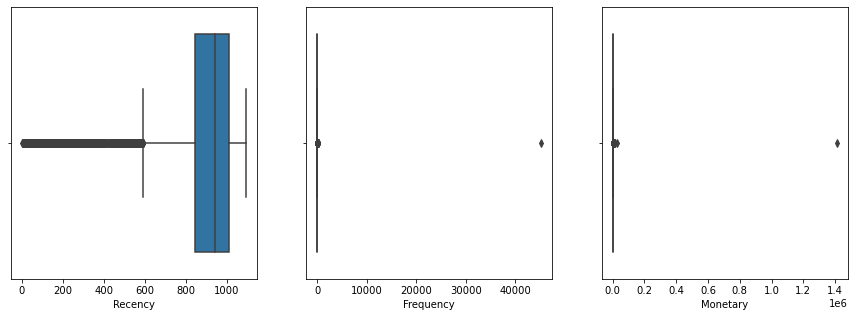

In [17]:
#Outlier Detection

fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(RFM.Recency, ax = axs[0])
sns.boxplot(RFM.Frequency, ax = axs[1])
sns.boxplot(RFM.Monetary, ax = axs[2])

plt.tight_layout
plt.show()

### Part 2: Data Normalisation and Standardization

C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


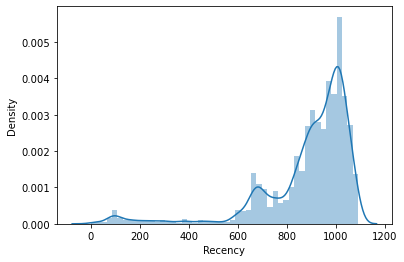

In [28]:
#Recency distribution plot
x = RFM['Recency']
ax = sns.distplot(x)

C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


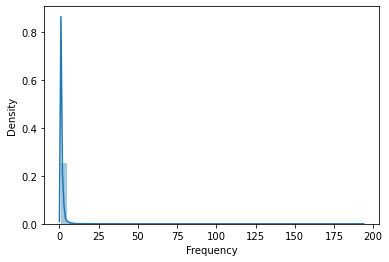

In [29]:
#Frequency distribution plot, taking observations which have frequency less than 1000
import seaborn as sns
x = RFM.query('Frequency < 1000')['Frequency']

ax = sns.distplot(x)

C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


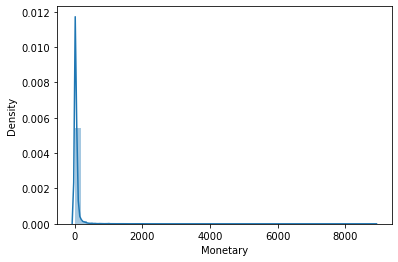

In [30]:
#Monateray distribution plot, taking observations which have monetary value less than 10000
import seaborn as sns
x = RFM.query('Monetary < 10000')['Monetary']

ax = sns.distplot(x)

In [18]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFM['Recency'] = [handle_neg_n_zero(x) for x in RFM.Recency]
RFM['Monetary'] = [handle_neg_n_zero(x) for x in RFM.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFM[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


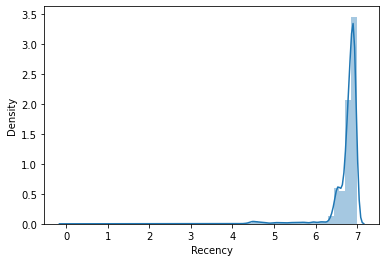

In [19]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


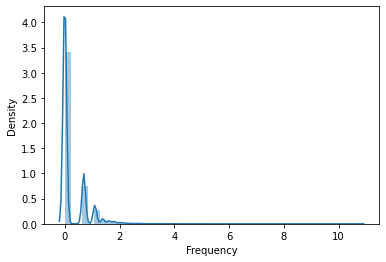

In [20]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

C:\Users\Eunice\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


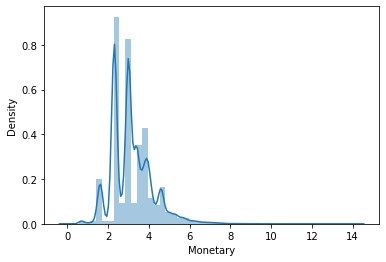

In [21]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [22]:
#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFM.index, columns = Log_Tfd_Data.columns)
Scaled_Data

,Recency,Frequency,Monetary
DONOR_USER_ID,,,
0.0,0.420072,6.479250,2.050361
8102.0,0.601225,-0.528132,0.544490
9185.0,-3.144167,2.249172,0.544490
265715.0,-1.372634,-0.528132,2.072316
275878.0,-5.033332,-0.528132,0.257087
...,...,...,...
75931599.0,-8.089403,-0.528132,1.458591
75935577.0,-8.270555,-0.528132,0.257087
75941911.0,-9.178672,-0.528132,-1.531197


### Part 3: Cluster Validation

In [36]:
#Obtaining cluster tendency using Hopkins Statistics

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [37]:
hopkins(Scaled_Data)

0.9977389510934029

### Part 4: Optimal Number of Clusters

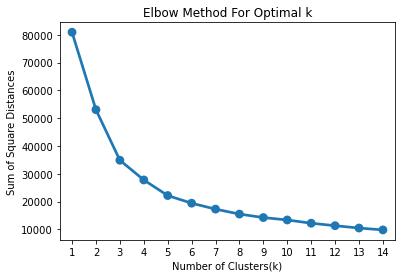

In [38]:
#Elbow Method

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [39]:
# Gap Method

def KMeans_clustering_func(X, k):
    
    # Include any clustering Algorithm that can return cluster centers
    
    m = KMeans(random_state=11, n_clusters=k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

#Create a wrapper around OptimalK to extract cluster centers and cluster labels
optimalK = OptimalK(clusterer=KMeans_clustering_func)

#Run optimal K on the input data (Scaled_Data) and number of clusters
n_clusters = optimalK(Scaled_Data, cluster_array=np.arange(1, 15))

print('Optimal clusters: ', n_clusters)

#Gap Statistics data frame
optimalK.gap_df[['n_clusters', 'gap_value']]

Optimal clusters:  14


,n_clusters,gap_value
0,1.0,3.254838
1,2.0,3.213843
2,3.0,3.413199
3,4.0,3.424081
4,5.0,3.520507
5,6.0,3.519385
6,7.0,3.523095
7,8.0,3.515209
8,9.0,3.494577
9,10.0,3.484849


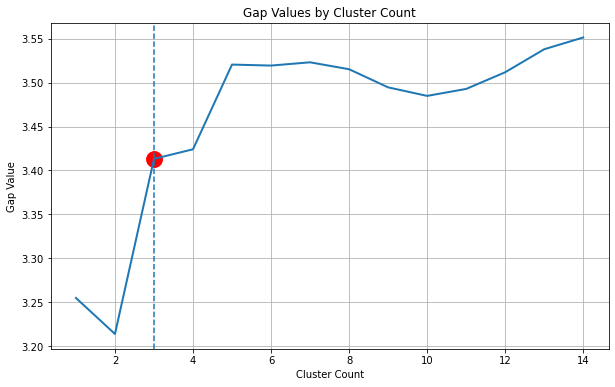

In [40]:
# Plot
plt.figure(figsize=(10,6))
n_clusters=3
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=2)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.axvline(3, linestyle="--")
plt.show()

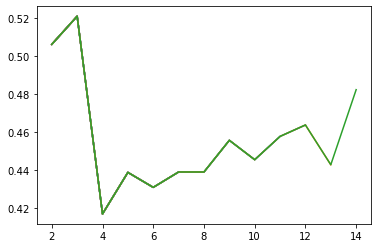

In [41]:
# Silhouette Method
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(Scaled_Data)
    sse_.append([k, silhouette_score(Scaled_Data, kmeans.labels_)])
    plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

### Part 5: Clustering

In [25]:
#Perform K-Mean Clustering, using random state for reproducibility
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++',
                     max_iter= 1000, n_init=1, verbose=0, random_state=3425)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFM['Cluster'] = KMean_clust.labels_
RFM.head()

,Recency,Frequency,Monetary,Cluster
DONOR_USER_ID,,,,
0.0,1005,33,181.0,1
8102.0,1086,1,40.0,0
9185.0,221,4,40.0,2
265715.0,469,1,185.0,1
275878.0,99,1,30.0,2


In [26]:
# Count distinct values in a cluster
RFM['Cluster'].value_counts()

0    19211
1     6817
2      934
Name: Cluster, dtype: int64

In [27]:
# Returning average RFM values
km_clusters_value = pd.DataFrame(RFM.groupby(["Cluster"]).Monetary.mean())
km_clusters_frequency = pd.DataFrame(RFM.groupby(["Cluster"])['Frequency'].mean())
km_clusters_recency = pd.DataFrame(RFM.groupby(["Cluster"]).Recency.mean()) 

In [29]:
# Combining RFM means and Clusters
df = pd.concat([pd.Series([0,1,2]), km_clusters_value, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["Cluster", "Monetary_mean", "Frequency_mean", "Recency_mean"]
df.head()

,Cluster,Monetary_mean,Frequency_mean,Recency_mean
0,0,21.479205,1.022175,917.874083
1,1,126.914144,3.091242,898.889394
2,2,1639.017131,50.557816,148.558887


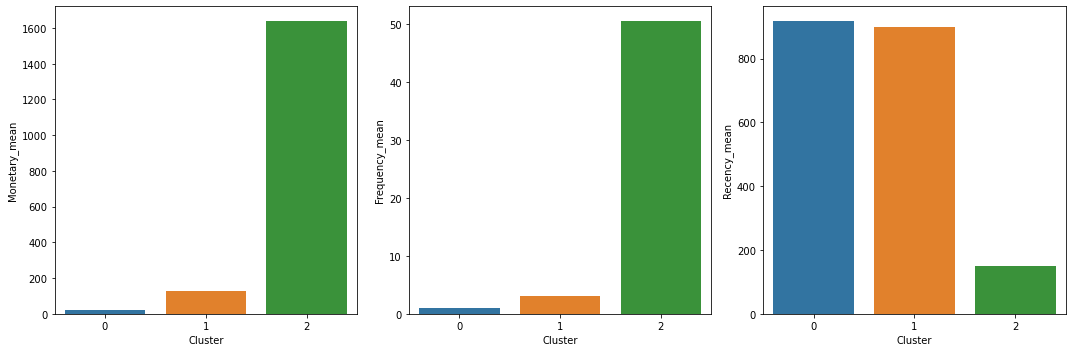

In [30]:
# Plotting donor segments
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.barplot(x=df.Cluster, y=df.Monetary_mean, ax = axs[0])
sns.barplot(x=df.Cluster, y=df.Frequency_mean, ax = axs[1])
sns.barplot(x=df.Cluster, y=df.Recency_mean, ax = axs[2])
plt.tight_layout()            
plt.show()

## Exporting Transformed Data Back to SQL Database

In [47]:
quoted = urllib.parse.quote_plus("Driver={SQL Server Native Client 11.0};"
                  "Server=Insert_server_name;"
                  "Database=Insert_database_name;"
                  "Trusted_Connection=yes;")
engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

RFM.to_sql('Segmentation2', schema='dbo', con = engine, if_exists = 'replace')